# Лабораторная работа 1. Классические методы построения рекомендаций.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/main/homeworks/hw_01/rs_hw01.ipynb)

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций. 

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit. Пожалуйста, посмотрите [документацию](https://benfred.github.io/implicit/api/models/recommender_base.html) и примеры использования на [github](https://github.com/benfred/implicit), чтобы лучше разобраться с форматом входных данных. 

Вопросы по заданию можно писать в чат курса. Ссылка на форму для отправки решений будет дана в чате.

In [1]:
!pip install rs-datasets -q
!pip install "ipython<9" -q

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from rs_datasets import MovieLens

In [3]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [4]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [5]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [6]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(6)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48


### Анализ по юзерам

In [7]:
user_stats = reviews.groupby('user_id').agg(
    items_cnt=('item_id', 'nunique'),
    avg_rating=('relevance', lambda x: round(x.mean(), 3)),
    reviews_cnt=('relevance', 'size'),
    min_rating=('relevance', 'min'),
    max_rating=('relevance', 'max'),
    first_date=('timestamp', lambda x: min(x)),
    last_date=('timestamp', lambda x: max(x))
).reset_index()

user_stats['first_date'] = user_stats['first_date'].dt.normalize()
user_stats['last_date'] = user_stats['last_date'].dt.normalize()
user_stats['duration'] = (user_stats['last_date'] - user_stats['first_date']).dt.days

user_stats = user_stats.sort_values('reviews_cnt', ascending=False).reset_index(drop=True)
user_stats['rank'] = range(len(user_stats))
user_stats

,user_id,items_cnt,avg_rating,reviews_cnt,min_rating,max_rating,first_date,last_date,duration,rank
0,4169,2314,3.552,2314,1,5,2000-08-03,2002-06-15,681,0
1,1680,1850,3.556,1850,1,5,2000-11-20,2000-12-07,17,1
2,4277,1743,4.135,1743,2,5,2000-08-03,2003-02-25,936,2
3,1941,1595,3.055,1595,1,5,2000-11-20,2002-09-01,650,3
4,1181,1521,2.816,1521,1,5,2000-11-22,2002-05-12,536,4
...,...,...,...,...,...,...,...,...,...,...
6035,708,20,3.850,20,1,5,2000-11-29,2000-11-29,0,6035
6036,703,20,4.100,20,2,5,2000-11-30,2000-11-30,0,6036
6037,665,20,3.500,20,1,5,2000-12-01,2000-12-01,0,6037
6038,2160,20,3.950,20,1,5,2000-11-19,2000-11-19,0,6038


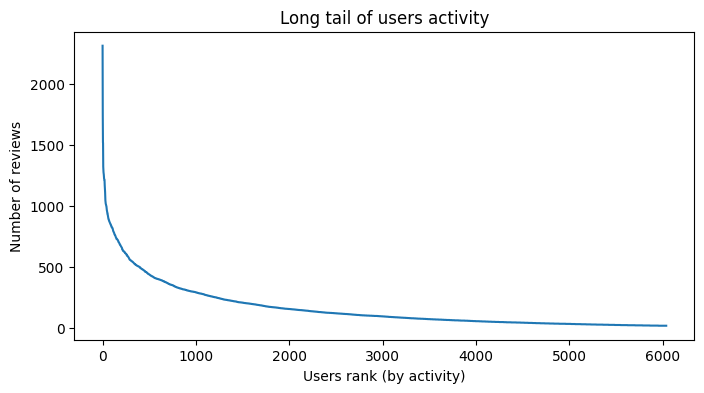

Данные сильно несбалансированы по юзерам, осторожно с cold-start


In [8]:
plt.figure(figsize=(8, 4))
plt.plot(user_stats['rank'], user_stats['items_cnt'])
plt.xlabel('Users rank (by activity)')
plt.ylabel('Number of reviews')
plt.title('Long tail of users activity')
plt.show()

print('Данные сильно несбалансированы по юзерам, осторожно с cold-start')

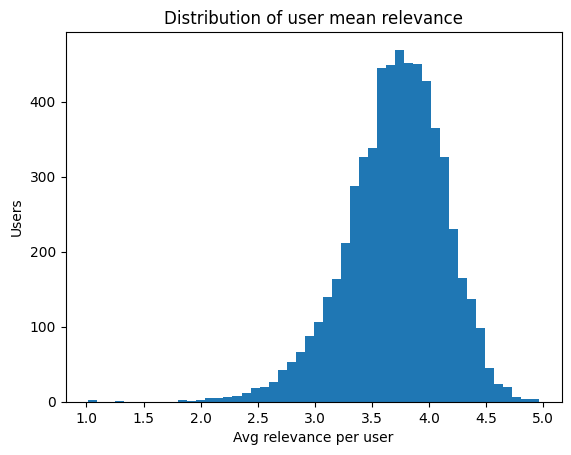

In [9]:
plt.hist(user_stats['avg_rating'], bins=50)
plt.xlabel("Avg relevance per user")
plt.ylabel("Users")
plt.title("Distribution of user mean relevance")
plt.show()


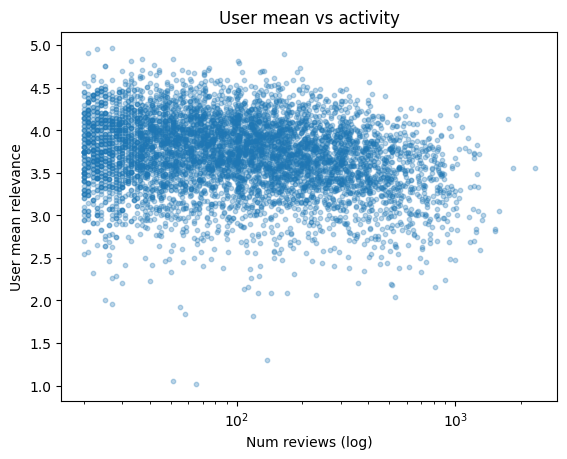

In [10]:
cnt = user_stats['items_cnt']  # Series user_id -> num_reviews
df = (
    pd.DataFrame({"cnt": cnt, "mean": user_stats['avg_rating']})
      .dropna()
)

plt.scatter(df["cnt"], df["mean"], s=10, alpha=0.3)
plt.xscale("log")
plt.xlabel("Num reviews (log)")
plt.ylabel("User mean relevance")
plt.title("User mean vs activity")
plt.show()

/tmp/ipykernel_53368/2353235678.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = user_stats.groupby("bin")["avg_rating"]


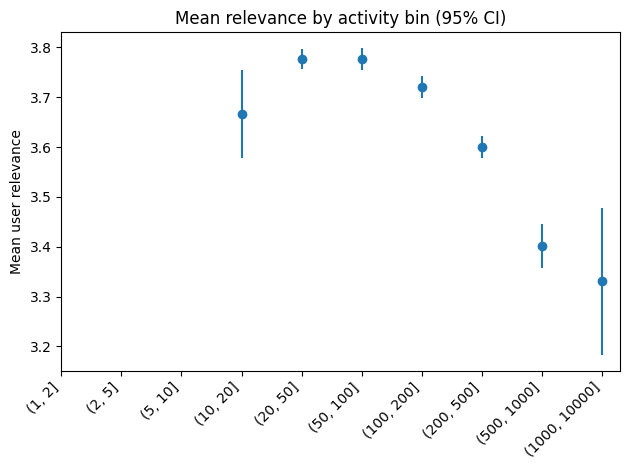

In [11]:
bins = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10_000]
user_stats["bin"] = pd.cut(user_stats["items_cnt"], bins=bins, right=True)

g = user_stats.groupby("bin")["avg_rating"]
m = g.mean()
se = g.sem()  # стандартная ошибка среднего

plt.errorbar(range(len(m)), m, yerr=1.96*se, fmt="o")
plt.xticks(range(len(m)), [str(b) for b in m.index], rotation=45, ha="right")
plt.ylabel("Mean user relevance")
plt.title("Mean relevance by activity bin (95% CI)")
plt.tight_layout()
plt.show()

In [12]:
g = user_stats.groupby("bin").agg(
    users=("avg_rating", "size"),
    mean_user_mean=("avg_rating", "mean"),
)
print(g)

               users  mean_user_mean
bin                                 
(1, 2]             0             NaN
(2, 5]             0             NaN
(5, 10]            0             NaN
(10, 20]          86        3.666279
(20, 50]        1707        3.775954
(50, 100]       1338        3.776880
(100, 200]      1331        3.719857
(200, 500]      1182        3.599747
(500, 1000]      356        3.400992
(1000, 10000]     40        3.330350


/tmp/ipykernel_53368/3646823690.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = user_stats.groupby("bin").agg(


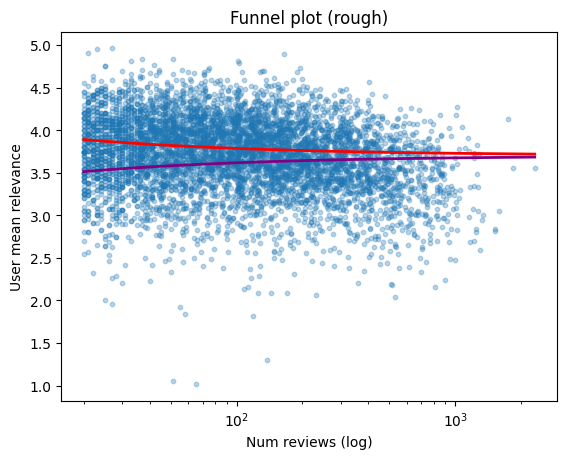

In [13]:
mu = user_stats["avg_rating"].mean()
sigma = user_stats["avg_rating"].std()  # грубо; лучше std по всем взаимодействиям

n = user_stats["items_cnt"].values
upper = mu + 1.96 * sigma / np.sqrt(n)
lower = mu - 1.96 * sigma / np.sqrt(n)

plt.scatter(user_stats["items_cnt"], user_stats["avg_rating"], s=10, alpha=0.3)
plt.plot(user_stats["items_cnt"], upper, linewidth=2, color='red')
plt.plot(user_stats["items_cnt"], lower, linewidth=2, color='purple')
plt.xscale("log")
plt.xlabel("Num reviews (log)")
plt.ylabel("User mean relevance")
plt.title("Funnel plot (rough)")
plt.show()


### Анализ по айтемам

In [14]:
item_stats = reviews.groupby('item_id').agg(
    items_cnt=('user_id', 'nunique'),
    avg_rating=('relevance', lambda x: round(x.mean(), 3)),
    reviews_cnt=('relevance', 'size'),
    min_rating=('relevance', 'min'),
    max_rating=('relevance', 'max'),
    first_date=('timestamp', lambda x: min(x)),
    last_date=('timestamp', lambda x: max(x))
).reset_index()

item_stats['first_date'] = item_stats['first_date'].dt.normalize()
item_stats['last_date'] = item_stats['last_date'].dt.normalize()
item_stats['duration'] = (item_stats['last_date'] - item_stats['first_date']).dt.days

item_stats = item_stats.sort_values('reviews_cnt', ascending=False).reset_index(drop=True)
item_stats['rank'] = range(len(item_stats))
item_stats

,item_id,items_cnt,avg_rating,reviews_cnt,min_rating,max_rating,first_date,last_date,duration,rank
0,2858,3428,4.317,3428,1,5,2000-04-25,2003-02-27,1038,0
1,260,2991,4.454,2991,1,5,2000-04-25,2003-02-22,1033,1
2,1196,2990,4.293,2990,1,5,2000-04-26,2003-02-27,1037,2
3,1210,2883,4.023,2883,1,5,2000-04-25,2003-02-20,1031,3
4,480,2672,3.764,2672,1,5,2000-04-26,2003-02-06,1016,4
...,...,...,...,...,...,...,...,...,...,...
3701,402,1,3.000,1,3,3,2000-12-04,2000-12-04,0,3701
3702,2556,1,3.000,1,3,3,2000-11-26,2000-11-26,0,3702
3703,3904,1,1.000,1,1,1,2000-11-21,2000-11-21,0,3703
3704,2563,1,3.000,1,3,3,2000-11-26,2000-11-26,0,3704


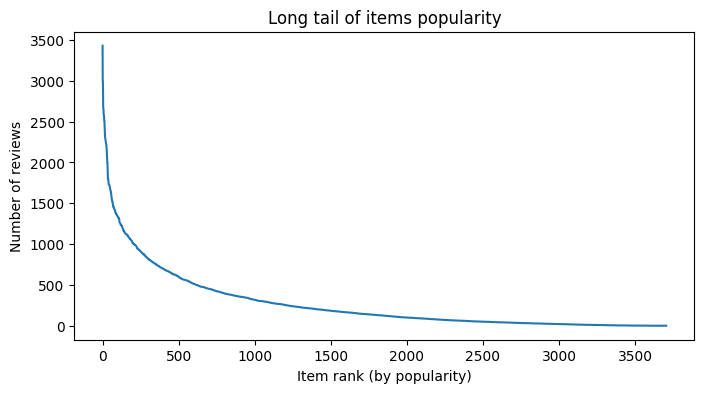

Данные сильно несбалансированы по айтемам. Модели часто склоняются к популярному
Коллаборативная фильтрация без контентных фичей будет работать плохо, эмбеддинги будут слабыми


In [15]:
plt.figure(figsize=(8, 4))
plt.plot(item_stats['rank'], item_stats['items_cnt'])
plt.xlabel('Item rank (by popularity)')
plt.ylabel('Number of reviews')
plt.title('Long tail of items popularity')
plt.show()

print('Данные сильно несбалансированы по айтемам. Модели часто склоняются к популярному')
print('Коллаборативная фильтрация без контентных фичей будет работать плохо, эмбеддинги будут слабыми')

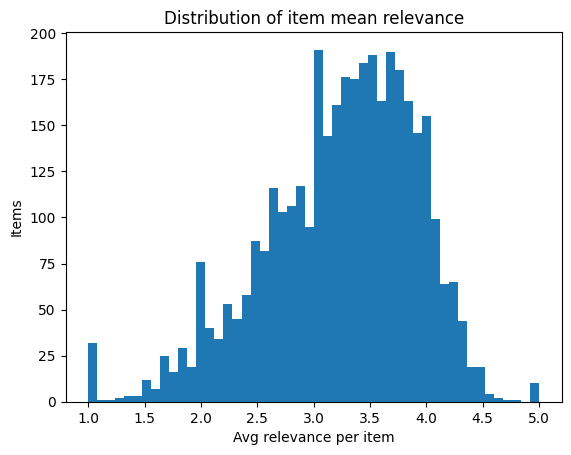

In [16]:
plt.hist(item_stats['avg_rating'], bins=50)
plt.xlabel("Avg relevance per item")
plt.ylabel("Items")
plt.title("Distribution of item mean relevance")
plt.show()

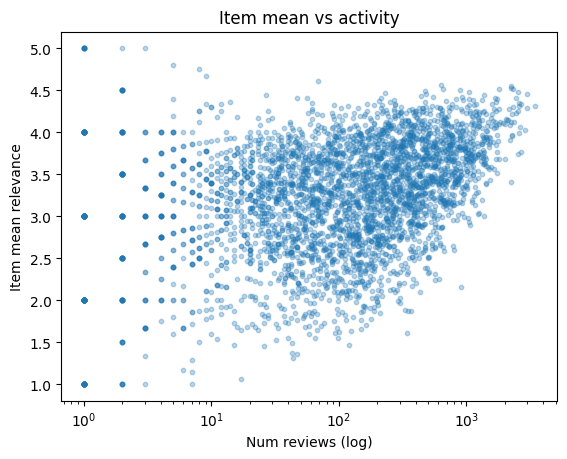

In [17]:
cnt = item_stats['items_cnt']  # Series user_id -> num_reviews
df = (
    pd.DataFrame({"cnt": cnt, "mean": item_stats['avg_rating']})
      .dropna()
)

plt.scatter(df["cnt"], df["mean"], s=10, alpha=0.3)
plt.xscale("log")
plt.xlabel("Num reviews (log)")
plt.ylabel("Item mean relevance")
plt.title("Item mean vs activity")
plt.show()

/tmp/ipykernel_53368/19975283.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = item_stats.groupby("bin")["avg_rating"]


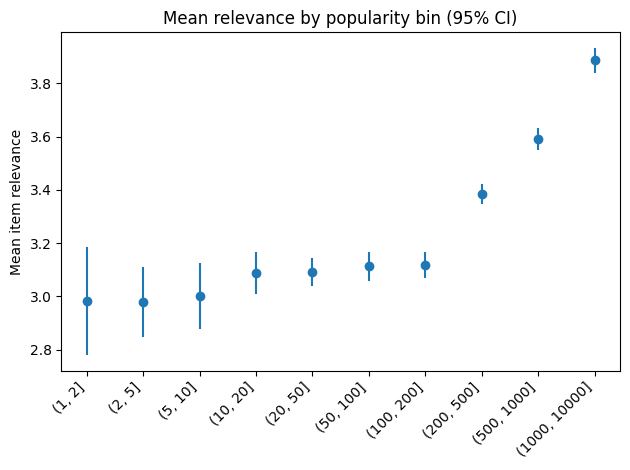

In [18]:
bins = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10_000]
item_stats["bin"] = pd.cut(item_stats["items_cnt"], bins=bins, right=True)

g = item_stats.groupby("bin")["avg_rating"]
m = g.mean()
se = g.sem()  # стандартная ошибка среднего

plt.errorbar(range(len(m)), m, yerr=1.96*se, fmt="o")
plt.xticks(range(len(m)), [str(b) for b in m.index], rotation=45, ha="right")
plt.ylabel("Mean item relevance")
plt.title("Mean relevance by popularity bin (95% CI)")
plt.tight_layout()
plt.show()

### Активность по времени

In [19]:
r = reviews.copy()
r["dt"] = pd.to_datetime(r["timestamp"], unit="s")
r = r.sort_values("dt").set_index("dt")

/tmp/ipykernel_53368/2537820605.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  counts_m = r["relevance"].resample("M").size()


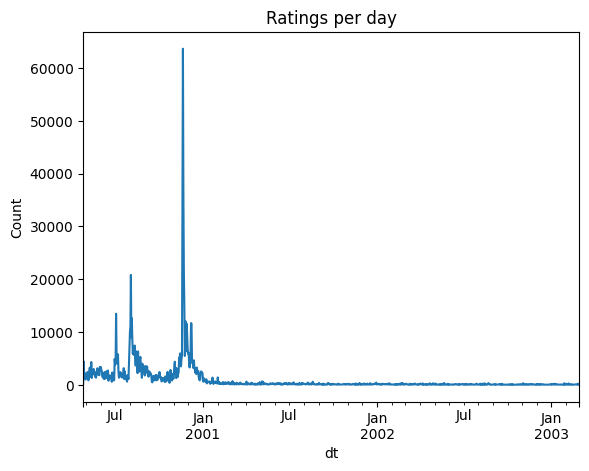

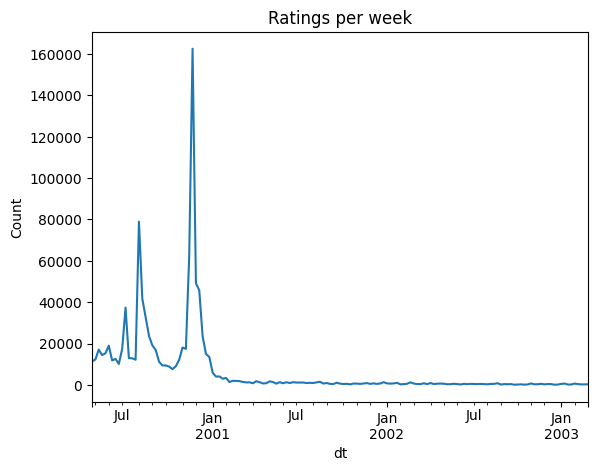

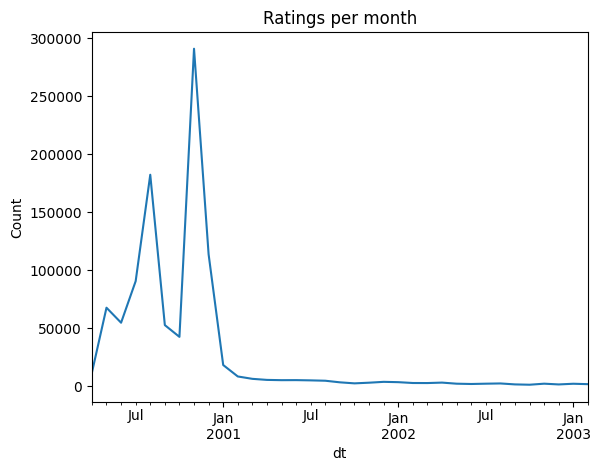

In [20]:
counts_d = r["relevance"].resample("D").size()
counts_w = r["relevance"].resample("W").size()
counts_m = r["relevance"].resample("M").size()

counts_d.plot()
plt.title("Ratings per day")
plt.ylabel("Count")
plt.show()

counts_w.plot()
plt.title("Ratings per week")
plt.ylabel("Count")
plt.show()

counts_m.plot()
plt.title("Ratings per month")
plt.ylabel("Count")
plt.show()

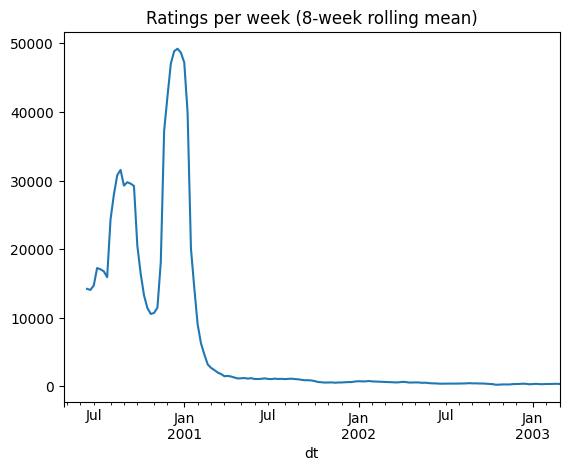

In [21]:
counts_w.rolling(8).mean().plot()
plt.title("Ratings per week (8-week rolling mean)")
plt.show()

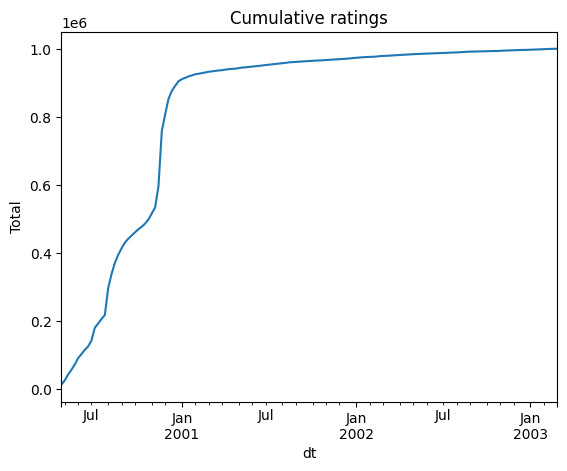

In [22]:
cum = counts_w.cumsum()
cum.plot()
plt.title("Cumulative ratings")
plt.ylabel("Total")
plt.show()

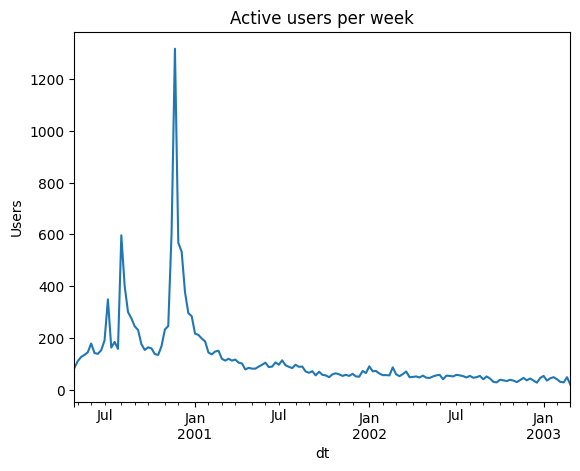

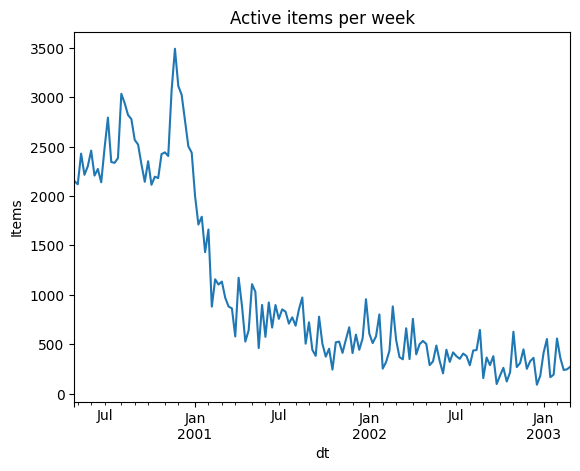

In [23]:
u_w = r["user_id"].resample("W").nunique()
i_w = r["item_id"].resample("W").nunique()

u_w.plot()
plt.title("Active users per week")
plt.ylabel("Users")
plt.show()

i_w.plot()
plt.title("Active items per week")
plt.ylabel("Items")
plt.show()

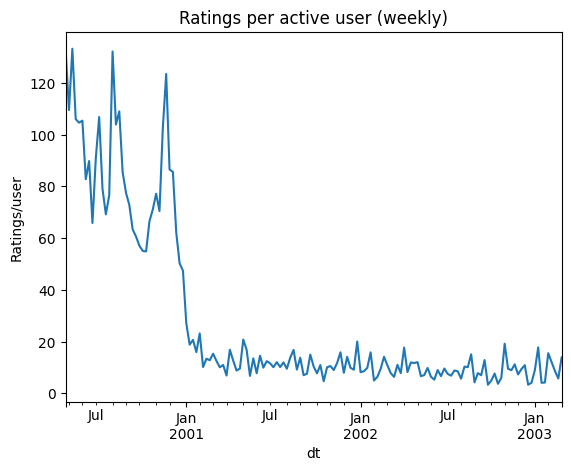

In [24]:
ru_w = r.groupby(pd.Grouper(freq="W"))["relevance"].size()
u_w = r.groupby(pd.Grouper(freq="W"))["user_id"].nunique()
(ru_w / u_w).plot()
plt.title("Ratings per active user (weekly)")
plt.ylabel("Ratings/user")
plt.show()

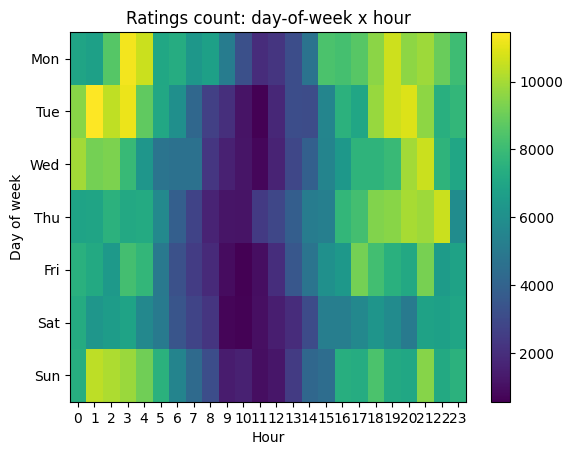

In [25]:
tmp = reviews.copy()
tmp["dt"] = pd.to_datetime(tmp["timestamp"], unit="s")
tmp["dow"] = tmp["dt"].dt.dayofweek   # 0=Mon
tmp["hour"] = tmp["dt"].dt.hour

pivot = tmp.pivot_table(index="dow", columns="hour", values="relevance", aggfunc="size", fill_value=0)

plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xticks(range(24), range(24))
plt.title("Ratings count: day-of-week x hour")
plt.xlabel("Hour")
plt.ylabel("Day of week")
plt.colorbar()
plt.show()


## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [26]:
# YOUR CODE HERE
reviews["timestamp"] = pd.to_datetime(reviews["timestamp"])

train = reviews[reviews['timestamp'] < '2000-12-01'].copy()
val = reviews[
    (reviews["timestamp"] >= "2000-12-01") &
    (reviews["timestamp"] <  "2001-01-01") &
    (reviews["relevance"] >  3)
].copy()

warm_users = set(train["user_id"].unique())
val = val[val["user_id"].isin(warm_users)].copy()

In [27]:
assert train.shape[0] == 791270
assert val.shape[0] == 15269

In [28]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [29]:
get_log_info(val)

Длина лога = 15269,
количество пользователей = 538,
количество объектов = 2359


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [30]:
%%time
# YOUR CODE HERE
rng = np.random.default_rng(SEED)
users = val["user_id"].unique()
item_pool = train["item_id"].unique()

seen = None
seen = train.groupby("user_id")["item_id"].apply(set).to_dict()

gt_items = val.groupby("user_id")["item_id"].apply(set).to_dict()
rows = []
for u in users:
    u_seen = seen.get(u, set())
    candidates = np.array([i for i in item_pool if i not in u_seen])
    sampled = rng.choice(candidates, size=K, replace=False)
    u_gt = gt_items.get(u, set())
    for i in sampled:
        if i in u_gt:
            rel = 1
        else:
            rel = 0
        rows.append((u, i, rel))
random_pred = pd.DataFrame(rows, columns=["user_id", "item_id", "relevance"])

CPU times: user 333 ms, sys: 0 ns, total: 333 ms
Wall time: 301 ms


In [31]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [32]:
random_pred.sample(6)

,user_id,item_id,relevance
799,795,2852,0
7504,3054,3642,0
5505,2078,313,0
6964,2786,2968,0
3697,1579,98,0
10625,5920,33,0


In [6]:
grouped_preds = random_pred.groupby('user_id').agg(
    pred_list=('item_id', lambda x: list(x)),
    gt_list=('relevance', lambda x: list(x))
)
grouped_preds.head(3)

NameError: name 'random_pred' is not defined

## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде

### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [33]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    dcg = 0.0
    is_binary = row["gt_list"] and all((x == 0 or x == 1) for x in row["gt_list"])

    for j, elem in enumerate(row["pred_list"][:k], start=1):
        if is_binary:
            rel = row["gt_list"][j-1]
        else:
            rel = int(elem in row["gt_list"])
        dcg += rel / math.log2(j + 1)
    
    m = min(len(row["gt_list"]), k)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, m + 1))

    return 0.0 if idcg == 0.0 else dcg / idcg

In [34]:
def ndcg_total(df, k):
    df['ndcg'] = df.apply(lambda row: ndcg_user(row, k=K), axis=1)
    return df, round(df['ndcg'].mean(), 6)

In [35]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [37]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3
grouped_preds, rand_ndcg_total = ndcg_total(grouped_preds, k=K)
print('Random Recommendations nNDCG@k:', rand_ndcg_total)
grouped_preds.head(3)

Random Recommendations nNDCG@k: 0.007166


,pred_list,gt_list,ndcg
user_id,,,
670,"[2253, 1749, 543, 2287, 1312, 1115, 444, 1029,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
671,"[469, 3307, 3468, 838, 1977, 2715, 2277, 1632,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
673,"[601, 3433, 2864, 1999, 1553, 737, 1203, 3787,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


### HitRate
$$HitRate@K(u) = \max_{j \in [1..K]}\mathbb{1}_{r_{uj}}$$


$$ HitRate@K = \frac{\sum_{u=1}^{N}HitRate@K(u)}{N} $$

In [5]:
def hr_user(row, k):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [54]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        N = log["user_id"].nunique() # Число уникальных юзеров
        self.max_si = math.log2(N) # Максимально возможное число метрики

        item_users  = log.groupby("item_id")["user_id"].nunique()
        self.si = item_users.apply(lambda p: -math.log2(p / N)).to_dict() # Значение метрики для каждого итема

    def __call__(self, pred, k):
        pred_topk = (
            pred.sort_values(["user_id", "relevance"], ascending=[True, False])
                .groupby("user_id", as_index=False)
                .head(k)
        )
        
        pred_topk["self_info"] = pred_topk["item_id"].map(self.si).fillna(self.max_si)
        
        denom = k * self.max_si
        per_user = pred_topk.groupby("user_id")["self_info"].sum() / denom

        return round(float(per_user.mean()), 6)

In [55]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [ ]:
# YOUR CODE HERE: оценка 4 метрик для рекомендаций из задания 3


## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

In [ ]:
! pip install implicit

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.